# ***Bayesian Theory and Computation Assignment***

***Naman Chhibbar*** \
***MA21BTECH11011***

***Abhay Kumar*** \
***BM21BTECH11001***

## ***Questions:***

1. *Consider a random sample of size 10 from a $\text{Binomial}(k=5, p)$ as: (2, 3, 3, 5, 4, 4, 4, 4, 5, 5).
Consider a non-conjugate prior for p as $f(p) = e - e^p,~ 0 < p < 1$.
Implement a Metropolis-Hastings MCMC algorithm to generate a posterior sample of $p$ with size $1000$.*

2. *Consider a random sample of size 10 from $\text{Normal}(\mu, 1/\lambda)$ as (0.467707769, 0.875798555, 1.220012900, 1.197033111, 1.448898718, 1.379038660, 0.668658758, 1.662372651, 0.008833254, 1.203549611).
This is an example from today's class.
Consider the priors for the mean and variance $(1/\lambda)$ as discussed in today's class.
Use Gibbs sampling to generate a posterior sample of $(\mu, \lambda)$ with size 1000.*

*In both of the above cases, make the trace plots.
Use a burn-in period of 500 and a thinning period of 5 to create a posterior random sample of size 100.
Based on these, perform various Monte Carlo approximations: calculate the posteior mean and variance of the parameters, 95% central posterior intervals.
In the second case, you can do these individually for $\mu$ and $\lambda$.*

## ***Installing and Importing Dependencies***

In [ ]:
# Uncomment the following line to install the required packages
# !pip install -q numpy scipy matplotlib

In [ ]:
from collections.abc import Callable

import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

np.random.seed(69)

## ***Question 1***

### ***Given Sample and Prior***

In [ ]:
k = 5
sample = [2, 3, 3, 5, 4, 4, 4, 4, 5, 5]

def prior(p: float) -> float:
  return np.e - np.exp(p) if 0 < p < 1 else 0

def likelihood(
  p: float,
  k: int,
  data: list[int]
) -> float:
  return np.prod(st.binom.pmf(data, k, p))

### ***Run Metropolis-Hastings using Normal as Proposal Distribution***

In [ ]:
# Proposal distribution
def proposal_dist(
  p: float,
  sigma: float = .1
) -> float:
  return np.random.normal(p, sigma)

# Proposal distribution PDF
def proposal_dist_pdf(
  p: float,
  q: float,
  sigma: float = .1
) -> float:
  return st.norm.pdf(q, p, sigma)


def run_metropolis_hastings(
  state: float,
  proposal_dist: Callable[[float], float],
  proposal_dist_pdf: Callable[[float, float], float],
  target_dist: Callable[[float], float],
  num_iters: int
) -> list[float]:

  samples = [state]
  for _ in range(num_iters):

    # Propose a new state
    proposal = proposal_dist(state)

    # Acceptance probability
    numerator = target_dist(proposal) * proposal_dist_pdf(state, proposal)
    denominator = target_dist(state) * proposal_dist_pdf(proposal, state)
    alpha = numerator / denominator

    # Accept or reject the proposal
    if np.random.rand() < alpha:
      state = proposal
    samples.append(state)

  return samples

In [ ]:
burn_in = 500
thinning = 5
sample_size = 1000

# Target distribution
posterior = lambda p: prior(p) * likelihood(p, k, sample)

# Random start state
p = np.random.rand()

# Burn in period
burn_in_samples = run_metropolis_hastings(
  state=p,
  proposal_dist=proposal_dist,
  proposal_dist_pdf=proposal_dist_pdf,
  target_dist=posterior,
  num_iters=burn_in
)
p = burn_in_samples[-1]

# Collect samples
samples = run_metropolis_hastings(
  state=p,
  proposal_dist=proposal_dist,
  proposal_dist_pdf=proposal_dist_pdf,
  target_dist=posterior,
  num_iters=sample_size*thinning
)

# Thinning
posterior_samples = samples[::thinning]

### ***Trace Plot***

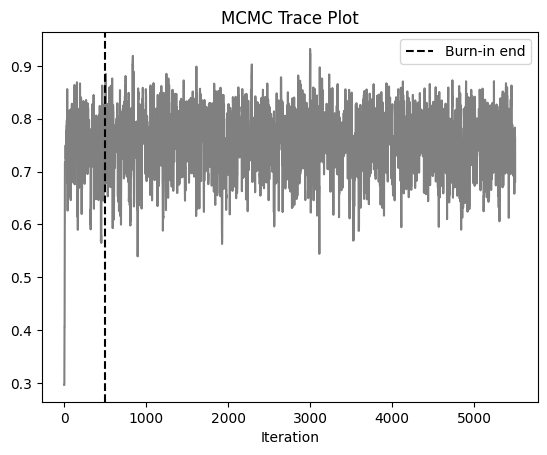

In [ ]:
plt.plot(burn_in_samples + samples, color="grey")
plt.axvline(x=burn_in, color="black", linestyle="--", label="Burn-in end")
plt.xlabel("Iteration")
plt.title("MCMC Trace Plot")
plt.legend()
plt.show()

### ***Monte-Carlo Approximations***

In [ ]:
# Posterior mean and variance
mu_mean = np.mean(posterior_samples)
mu_var = np.var(posterior_samples)

# 95% central interval
confidence = 95
percentiles = [(100 - confidence) / 2, (100 + confidence) / 2]
mu_ci = np.percentile(posterior_samples, percentiles)

print(
  f"Posterior mean: {mu_mean}",
  f"Posterior variance: {mu_var}",
  f"{confidence}% central interval: {mu_ci}",
  sep="\n"
)

Posterior mean: 0.7538538456952231
Posterior variance: 0.003363787878779033
95% central interval: [0.63161086 0.85865658]


## ***Question 2***

### ***Given Sample and Conditional Posteriors***

In [ ]:
sample = [
  0.467707769, 0.875798555, 1.220012900, 1.197033111, 1.448898718,
  1.379038660, 0.668658758, 1.662372651, 0.008833254, 1.203549611
]

def mu_posterior(
  lambda_: float,
  sample: list[float],
  mu0: float,
  lambda0: float
) -> float:
  
  n = len(sample)

  # Mean and variance for mu posterior given lambda
  mean = (mu0 * lambda0 + lambda_ * sum(sample)) / (lambda0 + n * lambda_)
  var = 1 / (lambda0 + n * lambda_)

  return np.random.normal(mean, var ** .5)

def lambda_posterior(
  mu: float,
  sample: list[float],
  a: float,
  b: float
) -> float:

  n = len(sample)

  # New a and b for lambda posterior given mu
  a_new = a + n / 2
  b_new = b + sum((x - mu) ** 2 for x in sample) / 2

  return np.random.gamma(a_new, 1 / b_new)

### ***Gibbs Sampling***

In [ ]:
def run_gibbs_sampling(
  mu: float,
  lambda_: float,
  sample: list[float],
  mu0: float,
  lambda0: float,
  a: float,
  b: float,
  num_iters: int
) -> tuple[list[float], list[float]]:

  mu_samples = [mu]
  lambda_samples = [lambda_]
  for _ in range(num_iters):

    # Sample mu and lambda
    mu = mu_posterior(lambda_, sample, mu0, lambda0)
    lambda_ = lambda_posterior(mu, sample, a, b)

    mu_samples.append(mu)
    lambda_samples.append(lambda_)

  return mu_samples, lambda_samples

In [ ]:
burn_in = 500
thinning = 5
sample_size = 1000

# Initialize start state
mu = np.random.rand()
lambda_ = np.random.rand()

# Initialize hyperparameters
mu0 = 0
lambda0 = 1
a = 1
b = 1

# Burn in period
mu_burn_in, lambda_burn_in = run_gibbs_sampling(
  mu=mu,
  lambda_=lambda_,
  sample=sample,
  mu0=mu0,
  lambda0=lambda0,
  a=a,
  b=b,
  num_iters=burn_in
)
mu = mu_burn_in[-1]
lambda_ = lambda_burn_in[-1]

# Collect samples
mu_samples, lambda_samples = run_gibbs_sampling(
  mu=mu,
  lambda_=lambda_,
  sample=sample,
  mu0=mu0,
  lambda0=lambda0,
  a=a,
  b=b,
  num_iters=sample_size*thinning
)

# Thinning
mu_posterior_samples = mu_samples[::thinning]
lambda_posterior_samples = lambda_samples[::thinning]

### ***Trace Plot***

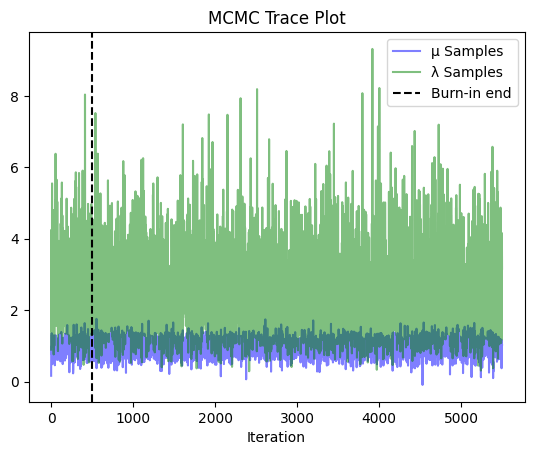

In [ ]:
plt.plot(mu_burn_in + mu_samples, label="\u03bc Samples", color="blue", alpha=.5)
plt.plot(lambda_burn_in + lambda_samples, label="\u03bb Samples", color="green", alpha=.5)
plt.axvline(x=burn_in, color="black", linestyle="--", label="Burn-in end")
plt.xlabel("Iteration")
plt.title("MCMC Trace Plot")
plt.legend()
plt.show()

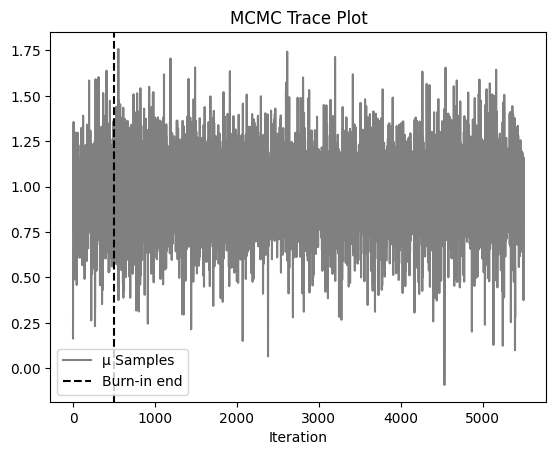

In [ ]:
plt.plot(mu_burn_in + mu_samples, label="\u03bc Samples", color="grey")
plt.axvline(x=burn_in, color="black", linestyle="--", label="Burn-in end")
plt.xlabel("Iteration")
plt.title("MCMC Trace Plot")
plt.legend()
plt.show()

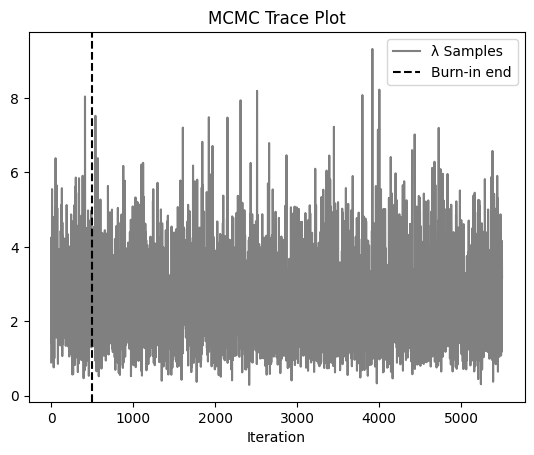

In [ ]:
plt.plot(lambda_burn_in + lambda_samples, label="\u03bb Samples", color="grey")
plt.axvline(x=burn_in, color="black", linestyle="--", label="Burn-in end")
plt.xlabel("Iteration")
plt.title("MCMC Trace Plot")
plt.legend()
plt.show()

### Monte-Carlo Approximations

In [ ]:
# Posterior mean and variance
mu_mean = np.mean(posterior_samples)
mu_var = np.var(posterior_samples)
lambda_mean = np.mean(lambda_posterior_samples)
lambda_var = np.var(lambda_posterior_samples)

# 95% central interval
confidence = 95
percentiles = [(100 - confidence) / 2, (100 + confidence) / 2]
mu_ci = np.percentile(posterior_samples, percentiles)
lambda_ci = np.percentile(lambda_posterior_samples, percentiles)

print(
  f"\u03bc Posterior mean: {mu_mean}",
  f"\u03bc Posterior variance: {mu_var}",
  f"\u03bc {confidence}% central interval: {mu_ci}",
  sep="\n"
)
print()
print(
  f"\u03bb Posterior mean: {lambda_mean}",
  f"\u03bb Posterior variance: {lambda_var}",
  f"\u03bb {confidence}% central interval: {lambda_ci}",
  sep="\n"
)

μ Posterior mean: 0.7538538456952231
μ Posterior variance: 0.003363787878779033
μ 95% central interval: [0.63161086 0.85865658]

λ Posterior mean: 2.5039666101696407
λ Posterior variance: 1.1382221494690636
λ 95% central interval: [0.87061309 4.97787777]
